In this assignment I will be impolementing Robust PCA Image Segmentation

In [1]:
import os
import sys
import PIL
import numpy as np
from glob import glob
import moviepy.editor as mpe
import matplotlib.pyplot as pt

from typing import Tuple, Any

In [2]:
def load_video(path: str) -> Tuple[Any, float]:
    try:
        video = mpe.VideoFileClip(path)
        print(f"Loaded video file from: {path}")
        print(f"Duration of loaded video: {video.duration}")
    except FileNotFoundException as err:
        print("Cannot find video file")
        raise err
    
    return video, video.duration, video.fps

In [3]:
def to_grayscale(mat: np.ndarray) -> np.ndarray:
    return np.dot(mat[...,:3], [0.299, 0.587, 0.114])

In [4]:
def scale_video(video, fps: int, scale_percent: int) -> Tuple[Any, int]:
    orig_n, orig_m, _ = video.get_frame(0).shape
    print(orig_n, orig_m)
    frame_n = int(orig_n * (scale_percent/100))
    frame_m = int(orig_m * (scale_percent/100))
    
    output: np.ndarray = np.zeros((frame_n*frame_m, fps*int(video.duration)))
    for frame in range(fps*int(video.duration)):
        current_frame = video.get_frame(frame/float(100))
        gray_frame = to_grayscale(current_frame)
        processed_image = PIL.Image.fromarray(gray_frame).resize(size=(frame_m, frame_n)) # pillow does width, height so switch the values
        output[:, frame] = np.array(processed_image).reshape(frame_n*frame_m)
    
    return output, frame_n, frame_m

In [5]:
path: str = "data/video.avi"
video, duration, fps = load_video(path)
num_frames = round(duration*fps)
video.subclip(0, 60).ipython_display(width=450)

t:  38%|███▊      | 161/420 [00:00<00:00, 1606.68it/s, now=None]

Loaded video file from: data/video.avi
Duration of loaded video: 113.57
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [6]:
print(f"Video duration: {duration}")
print(f"Video fps: {fps}")
print(f"Number of Frames: {num_frames}")

Video duration: 113.57
Video fps: 7.0
Number of Frames: 795


Now we can set the resolution of the image, 240 by 320 is large for visualization, so lets shrink a display version to a set percentage of that

We are also going to cheat and simulate that the video is running at 100fps so that the noise is amplified

In [7]:
scale_percent: int = 100
# HR, hr_n, hr_m = scale_video(video, 100, 100)
M, frame_n, frame_m = scale_video(video, 20, scale_percent)

240 320


In [8]:
print(f"Each image is now ({frame_n}, {frame_m})")
print(f"Data matrix shape is: {M.shape}")

Each image is now (240, 320)
Data matrix shape is: (76800, 2260)


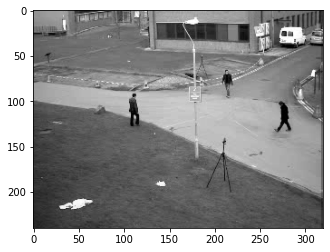

In [9]:
pt.imshow(M[:, 0].reshape(frame_n, frame_m), cmap="gray")

In [10]:
# pt.imshow(HR[:, 0].reshape(hr_n, hr_m), cmap='gray')

## Below is the data matrix we will be working with. This is constructed by turning each frame into a 1D vector and then stacking them in chronological order
The first column is the first frame, the second column is the second frame, and so on

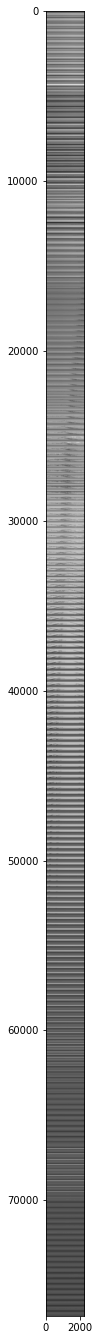

In [11]:
pt.figure(figsize=(24, 24))
pt.imshow(M, cmap='gray')

Time to use SVD to process this first!

First lets calculate U, S, VT

Also, as an aside (for an economy SVD where you truncate U and S to have rank m)
U is of shape n-by-m
S is of shape m-by-m
and VT is of shape m-by-n

so if you multiply them straight across you end up with an n-by-m matrix (which is your input)

you can "approximate" the original matrix with a lower rank by decreasing 'm' 

in this case, we make m = 1, so that each row is a linear combination of the first row (and that linear encoding is defined by the now vertical n-by-1 vector U)

In our case, we choose m = 1 because ideally this will give us the background because there is not enough information to render the "noise" i.e the small details that move in every frame. We hope that the background does not move every frame

Up first I will do this to our low rez video and then I will do it to our hi rez video


Helper function to do the low rank multiplication

In [12]:
# u, s, vt = np.linalg.svd(M, full_matrices=False)  # economy SVD

In [13]:
# def get_rank_n_matrix(u, s, vt, rank) -> np.ndarray:
#     return u[:, :rank] @ np.diag(s[:rank]) @ vt[:rank, :]

In [14]:
# low_rank = get_rank_n_matrix(u, s, vt, 1)

In [15]:
# print(low_rank.shape)

In [16]:
# pt.imshow(low_rank[:, 0].reshape(frame_n, frame_m), cmap='gray')

In [17]:
# pt.imshow(low_rank, cmap='gray')

In [18]:
# pt.imshow((M[:, 0] - low_rank[:, 0]).reshape(frame_n, frame_m), cmap='gray')

Now time to use something a little different

## Robust PCA

- Algorithm of Principal Component Pursuit by Alternating Directions
- reference: https://nbviewer.jupyter.org/github/fastai/numerical-linear-algebra/blob/master/nbs/3.%20Background%20Removal%20with%20Robust%20PCA.ipynb

- L = Low Rank Approximation
- S = Sparse Matrix Approximation

In [19]:
import fbpca 

TOL=1e-10
MAX_ITERS = 3

def converged(Z, d_norm):
    err = np.linalg.norm(Z, 'fro') / d_norm
    print('error: ', err)
    return err < TOL

def shrink(M, tau):
    S = np.abs(M) - tau
    return np.sign(M) * np.where(S>0, S, 0)

def _svd(M, rank): 
    return fbpca.pca(M, k=min(rank, np.min(M.shape)), raw=True)



def norm_op(M): 
    return _svd(M, 1)[1][0]


def svd_reconstruct(M, rank, min_sv):
    u, s, v = _svd(M, rank)
    s -= min_sv
    nnz = (s > 0).sum()
    return u[:,:nnz] @ np.diag(s[:nnz]) @ v[:nnz], nnz


def pcp(X, maxiter=10, k=10): # refactored
    m, n = X.shape
    trans = m<n
    
    if trans: 
        X = X.T; m, n = X.shape
    
    lamda = 1/np.sqrt(m)
    
    op_norm = norm_op(X)
    
    Y = np.copy(X) / max(op_norm, np.linalg.norm( X, np.inf) / lamda)
    
    mu = k*1.25/op_norm; mu_bar = mu * 1e7; rho = k * 1.5
    
    d_norm = np.linalg.norm(X, 'fro')
    L = np.zeros_like(X); sv = 1
    for i in range(maxiter):
        print("rank sv:", sv)
        X2 = X + Y/mu
        
        # update estimate of Sparse Matrix by "shrinking/truncating": original - low-rank
        S = shrink(X2 - L, lamda/mu)
        
        # update estimate of Low-rank Matrix by doing truncated SVD of rank sv & reconstructing.
        # count of singular values > 1/mu is returned as svp
        L, svp = svd_reconstruct(X2 - S, sv, 1/mu)
        
        # If svp < sv, you are already calculating enough singular values.
        # If not, add 20% (in this case 240) to sv
        sv = svp + (1 if svp < sv else round(0.05*n))
        
        # residual
        Z = X - L - S
        Y += mu*Z; mu *= rho
        
        if m > mu_bar:
            m = mu_bar

        if converged(Z, d_norm): 
            break
    
    if trans:
        L=L.T; S=S.T
    
    return L, S



In [20]:
L, S = pcp(M)

rank sv: 1
error:  0.1369858869366088
rank sv: 114
error:  0.03098127606166861
rank sv: 25
error:  0.004004855697032185
rank sv: 138
error:  0.00026514839995332625
rank sv: 251
error:  7.351594022905229e-06
rank sv: 159
error:  3.093687219154633e-08
rank sv: 272
error:  7.06920934671106e-10
rank sv: 160
error:  8.128552470408299e-12


In [21]:
print(L.shape)
print(S.shape)

(76800, 2260)
(76800, 2260)


### Our Low Rank Matrix obtained from RPCA

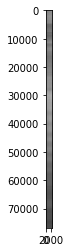

In [22]:
pt.imshow(L, cmap="gray")

### Our Sparse Matrix obtained from RPCA

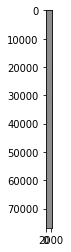

In [23]:
pt.imshow(S, cmap="gray")

## One frame from the video with the foreground removed

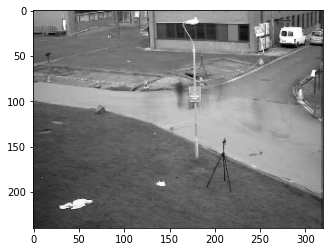

In [24]:
pt.imshow(L[:, 100].reshape(frame_n, frame_m), cmap='gray')

## One frame from the video with the background removed

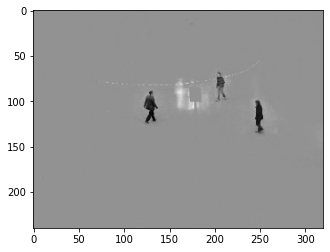

In [25]:
pt.imshow(S[:, 100].reshape(frame_n, frame_m), cmap='gray')

## The Original Frame

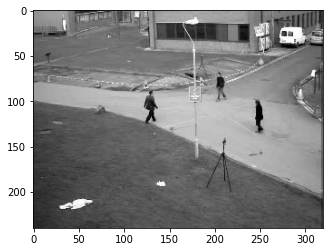

In [26]:
pt.imshow(M[:, 100].reshape(frame_n, frame_m), cmap='gray')

## Converting the processed data matrices to videos
There is a framerate issue in the reconstructed videos

In [27]:
import skvideo.io as skio

temp_video = L.reshape(frame_n, frame_m, L.shape[1])
temp_video_rgb = np.zeros((frame_n, frame_m, L.shape[1], 1))
temp_video_rgb[...,0] = temp_video
data = np.moveaxis(temp_video_rgb, 2, 0)
bgoutputdata = data.astype(np.uint8)
skio.vwrite("no_foreground.mp4", bgoutputdata)

v = S.reshape(frame_n, frame_m, S.shape[1])
vrgb = np.zeros((frame_n, frame_m, S.shape[1], 1))
vrgb[...,0] = v
data = np.moveaxis(vrgb, 2, 0)
fgoutputdata = 256-np.abs(data) # to fix the colors, the sparse matrix had negative values
skio.vwrite("no_background.mp4", fgoutputdata)

re_video = L + S
re_video = re_video.reshape(frame_n, frame_m, L.shape[1])
re_rgb = np.zeros((frame_n, frame_m, L.shape[1], 1))
re_rgb[...,0] = re_video
data = np.moveaxis(re_rgb, 2, 0)
reoutputdata = data.astype(np.uint8)
skio.vwrite("reconstructed.mp4", reoutputdata)

## The video constructed with the foreground removed

In [28]:
new_vid, duration, frames = load_video("no_foreground.mp4")
new_vid.subclip(0, 60).set_fps(24).ipython_display()

t:   0%|          | 0/1440 [00:00<?, ?it/s, now=None]

Loaded video file from: no_foreground.mp4
Duration of loaded video: 90.4
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


## The video constructed with the background removed

In [29]:
new_vid, duration, frames = load_video("no_background.mp4")
new_vid.subclip(0, 60).set_fps(100).ipython_display()

t:   0%|          | 0/6000 [00:00<?, ?it/s, now=None]

Loaded video file from: no_background.mp4
Duration of loaded video: 90.4
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


## The video constructed by adding the low rank and sparse components obtained through Robust Principal Component Analysis. This is identical to the original video (just in grayscale)

In [30]:
new_vid, duration, frames = load_video("reconstructed.mp4")
new_vid.subclip(0, 60).ipython_display()

t:   0%|          | 0/1500 [00:00<?, ?it/s, now=None]

Loaded video file from: reconstructed.mp4
Duration of loaded video: 90.4
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


## The original video

In [31]:
video.subclip(0, 60).ipython_display()

t:   0%|          | 0/420 [00:00<?, ?it/s, now=None]

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
